# Set Directory Path

In [12]:
import os
from pathlib import Path
p = Path.cwd().resolve()
while p != p.parent and not (p / 'requirements.txt').exists() and not (p / 'data').exists():
    p = p.parent

os.chdir(str(p/"src"))

# Checkpoint load model for basic Tier (0 - no augmentation)

In [13]:
import torch
import torchvision
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

if device.type == "cuda" and torch.cuda.device_count() > 1:
    torch.cuda.set_device(1)

num_classes = 10

model = torchvision.models.mobilenet_v2(weights=None)
model.classifier[1] = nn.Linear(1280, num_classes)

checkpoint_path = "../experiments/checkpoints/model_epoch_best_Tier0.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

# Handle both pure and wrapped checkpoints
if "state_dict" in checkpoint:
    state_dict = checkpoint["state_dict"]
elif "model_state_dict" in checkpoint:
    state_dict = checkpoint["model_state_dict"]
else:
    state_dict = checkpoint

model.load_state_dict(state_dict)
model = model.to(device)
model.eval()


Using device: cpu


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Identify target layer

In [14]:
target_layer = model.features[-1][0]
model.features[-1][0]


Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), bias=False)

# Load Images

In [18]:
from data import make_transforms

size = 224
seed = 67
augTier = 0

transforms_dict = make_transforms(size=size, seed=seed, augmentationTier=augTier)

val_transform = transforms_dict["val"]

from PIL import Image

img_path = "../data/Lily/Lily-Test (1).jpeg"
img = Image.open(img_path).convert("RGB")

img_tensor = val_transform(img).to(device)

# Generate Gradcam

In [19]:
from gradcam import grad_cam

cam = grad_cam(model, img_tensor, target_layer)
print("CAM shape:", cam.shape)


CAM shape: (256, 256)


# Plot Heatmap

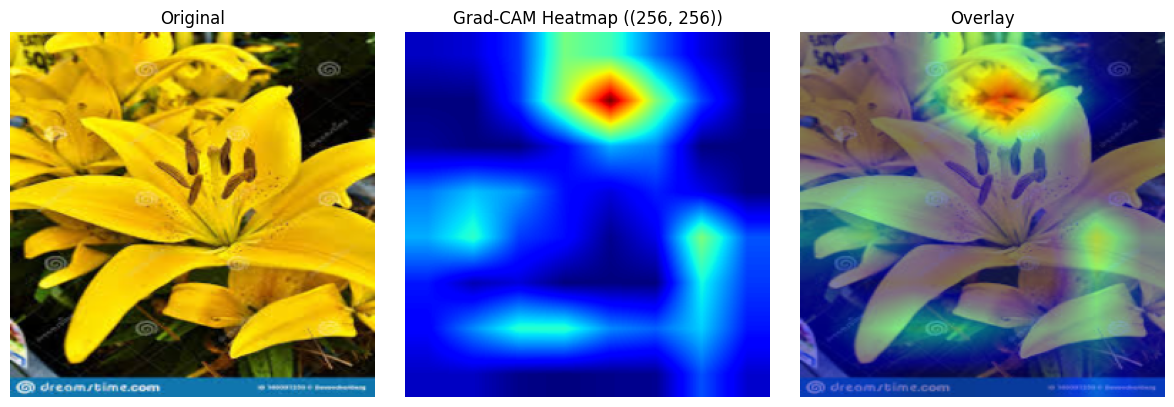

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# De-normalize for display
mean = np.array([0.485, 0.456, 0.406])
std  = np.array([0.229, 0.224, 0.225])

img_np = img_tensor.detach().cpu().permute(1,2,0).numpy()
img_np = np.clip((img_np * std + mean), 0, 1)

# Plot
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img_np)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(cam, cmap="jet")
plt.title(f"Grad-CAM Heatmap ({cam.shape})")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(img_np)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.title("Overlay")
plt.axis("off")

plt.tight_layout()
plt.show()
